# Basic Instrumental Variables calculation

In this example we show how to use the DoubleML functionality of Instrumental Variables (IVs) in the basic setting shown in the graph below, where:

- Z is the instrument
- C is a vector of unobserved confounders
- D is the decision or treatment variable
- Y is the outcome

So, we will first generate synthetic data using linear models compatible with the diagram, and then use the DoubleML package to estimate the causal effect from D to Y. 

We assume that you have basic knowledge of instrumental variables and linear regression.

In [7]:
from IPython.display import Image
from graphviz import Source
from numpy.random import seed, normal, binomial, uniform
from pandas import DataFrame
from sklearn.linear_model import LinearRegression, LogisticRegression
import doubleml as dml

seed(1234)

## Instrumental Variables Directed Acyclic Graph (IV - DAG)

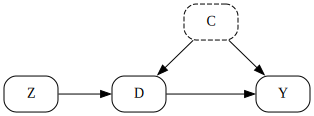

In [8]:
src = Source(
    """digraph G {
        rankdir="UD"

        node[shape=box, style=rounded]
        C[style="rounded,dashed"]
        {
            rank = same
            D
            Y
            Z
        }

        Z -> D[minlen=3]
        C -> D
        C -> Y
        D -> Y[minlen=5]
    }""")
src

## Data Simulation

This code generates `n` samples in which there is a unique binary confounder. The treatment is also a binary variable, while the outcome is a continuous linear model. 

The quantity we want to recover using IVs is the `decision_impact`, which is the impact of the decision variable into the outcome. 

In [9]:
n = 1000
instrument_impact = 0.7
decision_impact = - 2

confounder = binomial(1, 0.3, n)
instrument = binomial(1, 0.5, n)
decision = (uniform(0, 1, n) <= instrument_impact*instrument + 0.4*confounder).astype(int)
outcome = 30 + decision_impact*decision + 10 * confounder + normal(0, 2, n)

df = DataFrame({
    'instrument': instrument,
    'decision': decision,
    'outcome': outcome
})

## Naive estimation

We can see that if we make a direct estimation of the impact of the `decision` into the `outcome`, though the difference of the averages of outcomes between the two decision groups, we obtain a biased estimate. 

In [10]:
outcome_1 = df[df.decision==1].outcome.mean()
outcome_0 = df[df.decision==0].outcome.mean()
print(outcome_1 - outcome_0)

1.1099472942084532


## Using DoubleML

DoubleML assumes that there is at least one observed confounder. For this reason, we create a fake variable that doesn't bring any kind of information to the model, called `obs_confounder`.

To use the DoubleML we need to specify the Machine Learning methods we want to use to estimate the different relationships between variables:

- `ml_g` models the functional relationship betwen the `outcome` and the pair `instrument` and observed confounders `obs_confounders`. In this case we choose a `LinearRegression` because the outcome is continuous. 
- `ml_m` models the functional relationship betwen the `obs_confounders` and the `instrument`. In this case we choose a `LogisticRegression` because the outcome is dichotomic.
- `ml_r` models the functional relationship betwen the `decision` and the pair `instrument` and observed confounders `obs_confounders`. In this case we choose a `LogisticRegression` because the outcome is dichotomic.


Notice that instead of using linear and logistic regression, we could use more flexible models capable of dealing with non-linearities such as random forests, boosting, ... 

In [11]:
df['obs_confounders'] = 1

ml_g = LinearRegression()
ml_m = LogisticRegression(penalty=None)
ml_r = LogisticRegression(penalty=None)

obj_dml_data = dml.DoubleMLData(
    df, y_col='outcome', d_cols='decision', 
    z_cols='instrument', x_cols='obs_confounders'
)
dml_iivm_obj = dml.DoubleMLIIVM(obj_dml_data, ml_g, ml_m, ml_r)
dml_iivm_obj.fit().summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
decision,-1.917092,0.487533,-3.932227,0.000084,-2.87264,-0.961544


We can see that the causal effect is estimated without bias.